In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [12]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.4]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
        for t in range(start_time-1, end_time):
            window_y[t] = [0.6]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

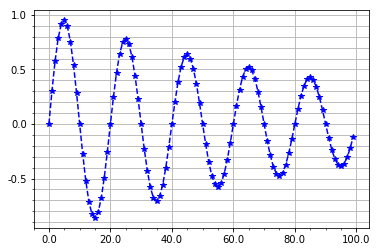

In [113]:
from pylab import *  
from matplotlib.ticker import MultipleLocator, FormatStrFormatter  
  
xmajorLocator   = MultipleLocator(20) #将x主刻度标签设置为20的倍数  
xmajorFormatter = FormatStrFormatter('%1.1f') #设置x轴标签文本的格式  
xminorLocator   = MultipleLocator(5) #将x轴次刻度标签设置为5的倍数  
  
ymajorLocator   = MultipleLocator(0.5) #将y轴主刻度标签设置为0.5的倍数  
ymajorFormatter = FormatStrFormatter('%1.1f') #设置y轴标签文本的格式  
yminorLocator   = MultipleLocator(0.1) #将此y轴次刻度标签设置为0.1的倍数  
  
t = arange(0.0, 100.0, 1)  
s = sin(0.1*pi*t)*exp(-t*0.01)  
  
ax = subplot(111) #注意:一般都在ax中设置,不再plot中设置  
plot(t,s,'--b*')  
  
#设置主刻度标签的位置,标签文本的格式  
ax.xaxis.set_major_locator(xmajorLocator)  
ax.xaxis.set_major_formatter(xmajorFormatter)  
  
ax.yaxis.set_major_locator(ymajorLocator)  
ax.yaxis.set_major_formatter(ymajorFormatter)  
  
#显示次刻度标签的位置,没有标签文本  
ax.xaxis.set_minor_locator(xminorLocator)  
ax.yaxis.set_minor_locator(yminorLocator)  
  
ax.xaxis.grid(True, which='major') #x坐标轴的网格使用主刻度  
ax.yaxis.grid(True, which='minor') #y坐标轴的网格使用次刻度  
  
show()  

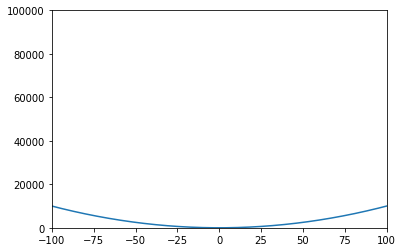

In [119]:

x = np.arange(-101, 101, 1)  
  
plt.plot(x, x ** 2)  
# 查看此时的x轴的最大值和最小猪和y轴的最大值最小值  
# print plt.axis()  
# 设置四个最值，列表传入  
plt.axis([-100, 100, 0, 100000])  
  
# 查看此时x轴的最大值和最小值  
# print plt.xlim()  
# 设置最大值和最小值(可以两个都设置，也可以只设置一个，只设置一个的时候要显式声明)  
plt.xlim(-200, 200)  
# 显式指定  
# plt.xlim(xmin = -200, xmax = 200)  
plt.xlim(xmin = -100)  
plt.xlim(xmax = 100)  
  
# 还有专门针对于y轴而言的ylim，xlim具备的方法ylim都具备，不再描述  
  
plt.show()  

[['-0.003559' '0.009071' '0.026518' '-0.002288' '0.013613' '0.010530']
 ['0.004972' '-0.001625' '0.026487' '-0.003561' '0.015347' '0.006482']
 ['-0.000283' '0.025864' '0.021098' '-0.002630' '0.005625' '-0.001173']
 ['0.006119' '0.031149' '0.019963' '0.000094' '0.004245' '0.003320']
 ['0.021047' '0.037510' '0.020888' '0.002438' '0.012541' '0.003717']
 ['0.012599' '0.038542' '0.020977' '0.001630' '0.019606' '0.000406']
 ['0.008371' '0.048085' '0.022039' '0.001455' '0.019296' '0.001957']
 ['0.016874' '0.046985' '0.017714' '0.002800' '0.016651' '0.006303']
 ['0.018984' '0.043768' '0.013447' '0.002728' '0.007557' '0.001196']
 ['0.007339' '0.041689' '0.012546' '0.000025' '0.003307' '-0.007024']]
['-0.003559', '0.004972', '-0.000283', '0.006119', '0.021047', '0.012599', '0.008371', '0.016874', '0.018984', '0.007339']


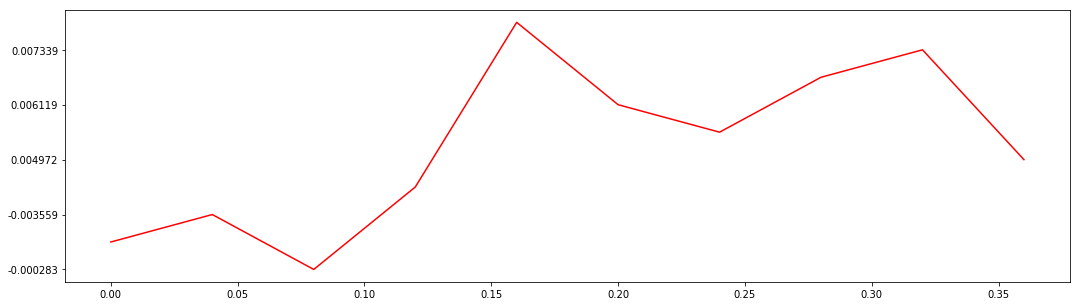

In [166]:
data_x = read_sensor("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_WC.csv")

print(data_x[:10])

start=0
end=10

y0 = [i[0] for i in data_x[start:end]]
print(y0)

#rotationRateX,rotationRateY,rotationRateZ,
#userAccelerationX,userAccelerationY,userAccelerationZ
plt.figure(figsize=(18, 5))

# plt.axis([0, 4, 0, 100])  

x = [i*1.0/25 for i in range(start, end)]
plt.plot(x, y0, 'r')
# plt.plot(x, [i[1] for i in data_x[start:end]], 'b')
# plt.plot(x, [i[2] for i in data_x[start:end]], 'y')

plt.locator_params(axis='y', nbins=6)
plt.show()

# plt.figure(figsize=(18, 3))
# plt.plot(x, [i[3] for i in data_x], 'r')
# plt.plot(x, [i[4] for i in data_x], 'b')
# plt.plot(x, [i[5] for i in data_x], 'y')
# plt.show()



In [ ]:
data_x = read_sensor("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_WC.csv")
length = len(data_x)

f = open("weallwalk/xml/T1_ID1_WC.xml")
cts = f.read()
f.close()

p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
all_foot = p_foot.findall(cts)

p_time = re.compile(r'<Time>(.*?)</Time>')
all_time = p_time.findall(cts)

strike_times = []
#L-1 R-0
strike_times.append([0.0, 0.5])
for i in range(len(all_foot)):
    if(all_foot[i]=='L'):
        strike_times.append([float(all_time[i]), 1])
    else:
        strike_times.append([float(all_time[i]), 0])
strike_times[-1][1] = 0.5
strike_times.append([length/25.0, 0.5])

window_y = []
feature_y = [0 for i in range(length)]
turn_y = [0 for i in range(length)]
origin_y = [0 for i in range(length)]
print(len(origin_y))
for i in strike_times[1:-1]:
#     print(round(i[0]*25))
    origin_y[round(i[0]*25)] = 1

strike_index=0
for i in range(length):
    if(i/25.0 >= strike_times[strike_index+1][0]):
        strike_index += 1
    window_y.append([strike_times[strike_index][1]])

p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

for i in range(len(all_info)):
    if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
        start_time = int(float(all_info[i][0])*25)
        end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
        for t in range(start_time-1, end_time):
            window_y[t] = [0.5]
            turn_y[t]=1

p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn

for i in range(len(all_feature)):
    start_time = int(float(all_feature[i][0])*25)
    end_time = int(float(all_feature[i][1])*25)
    for t in range(start_time-1, end_time):
        window_y[t] = [0.5]
        feature_y[t]=1

turn_y[0]=0
turn_y[-1]=0
        
start=60
end=860
        
plt.figure(figsize=(6, 2))
plt.title("Ground Truth Heel Strike Times")
plt.xlabel('time(seconds)')
# plt.ylabel('strike')

y0 = [0 for i in range(start, end)]
x = [i*1.0/25 for i in range(start, end)]
y1 = [i for i in origin_y[start:end]]
y2 = [i for i in window_y[start:end]]
y3 = [i for i in turn_y[start:end]]
y4 = [i for i in feature_y[start:end]]

plt.fill_between(x, y3, color = "#FFFACD", alpha = 0.5)  
plt.fill_between(x, y4, color = "#FFE4E1", alpha = 0.5) 

plt.plot(x, y1, '#FAEBD7', label='strike-1')
plt.plot(x, y2, '#FF4500', label='left-1/right-0')
# plt.plot(x, y3, 'g', label='xxx')
# plt.plot(x, y4, 'y', label='xxx')

# plt.plot([i*1.0/25 for i in range(start, end)], [i for i in origin_y[start:end]], '#FAEBD7', label='strike-1')
# plt.plot([i*1.0/25 for i in range(start, end)], [i for i in window_y[start:end]], '#FF4500', label='left-1/right-0')

# plt.fill(x, y1, color = "g", alpha = 0.3)  
# plt.fill(x, y2, color = "b", alpha = 0.3)

# plt.fill_between(x, y1, y2, facecolor = "yellow")  

plt.legend()
plt.show()


In [13]:
data_x = read_sensor("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_WC.csv")
data_y = read_xml("weallwalk/xml/T1_ID1_WC.xml", len(data_x))

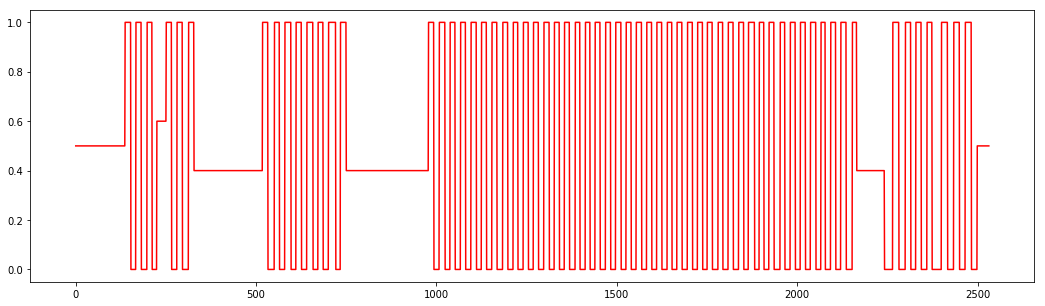

In [14]:
plt.figure(figsize=(18, 5))
plt.plot([i for i in data_y], 'r')
plt.show()